In [1]:
using DrWatson
@quickactivate :SwARExperiments

┌ Info: Precompiling SwARExperiments [370ede80-34d9-4915-b06a-c76e3bd073fe]
└ @ Base loading.jl:1662
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



In [2]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Plots
using Random
using Parameters
using LinearAlgebra
import ProgressMeter

In [3]:
using Plots
using PGFPlotsX
using LaTeXStrings
using ColorSchemes
pgfplotsx()
push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepgfplotslibrary{fillbetween}");

## Switching AR

## Generate AR

In [14]:
seed = 40
n_samples = 5000
n_states = 2
ar_order = 2
l_slice = 100
n_buckets = div(n_samples, l_slice)

coefs_set = [generate_coefficients(seed*i,  ar_order) for i in 1:n_states]
prec_set  = sample(MersenneTwister(seed), [0.01, 0.1, 1.0, 10.0, 100.0], n_states, replace=false)
# prec_set  = sample(MersenneTwister(seed), [inv(0.00012076092747935885), inv(0.0005755920568259142)], n_states, replace=false)

gen_A, gen_states, observations = generateSwAR(seed, n_samples, l_slice, n_states, ones(n_states), coefs_set, prec_set)
inputs, outputs = observations[1], observations[2];

priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A = generate_priors(coefs_set, prec_set)


(GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=10.000000000000002, b=100.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNormalMeanPrecision(
μ: [-0.3439319311678278, 0.13049770860794213]
Λ: [10000.0 0.0; 0.0 10000.0]
)
, MvNormalMeanPrecision(
μ: [0.9729989066143553, -0.840858756482024]
Λ: [10000.0 0.0; 0.0 10000.0]
)
], [(2, [1.0 0.0; 0.0 1.0]), (2, [1.0 0.0; 0.0 1.0])], [0.5, 0.5], [1.0 1.0; 1.0 1.0])

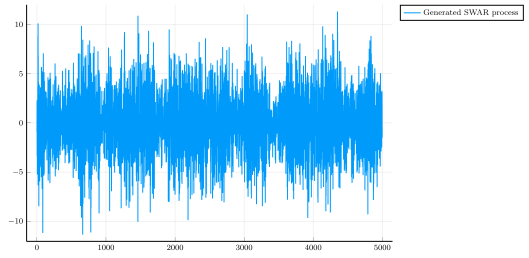

In [15]:
plot(outputs, label="Generated SWAR process")

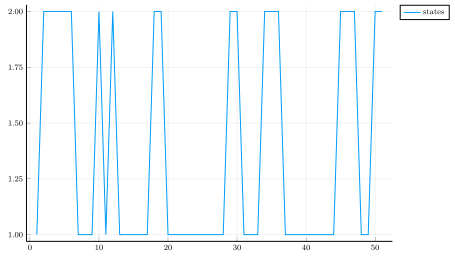

In [16]:
real_states = last.(findmax.(gen_states))
plot(real_states, label="states")

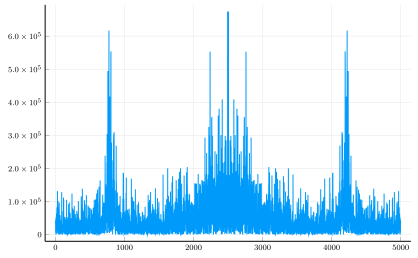

In [17]:
using FFTW
plot(abs.(fft(outputs)).^2, label=false)

In [18]:
# csep = 1000.0

priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A = generate_priors(coefs_set, prec_set)

parameters = SwARParameters(n_states, priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A)


SwARParameters(2, GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=10.000000000000002, b=100.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNormalMeanPrecision(
μ: [-0.3439319311678278, 0.13049770860794213]
Λ: [10000.0 0.0; 0.0 10000.0]
)
, MvNormalMeanPrecision(
μ: [0.9729989066143553, -0.840858756482024]
Λ: [10000.0 0.0; 0.0 10000.0]
)
], [(2, [1.0 0.0; 0.0 1.0]), (2, [1.0 0.0; 0.0 1.0])], [0.5, 0.5], [1.0 1.0; 1.0 1.0])

In [19]:

function softmax(v::Vector{Float64})
    r = v .- maximum(v)
    clamp!(r, -100.0, 0.0)
    exp.(r)./sum(exp.(r))
end

softmax (generic function with 1 method)

In [20]:
@marginalrule Transition(:out_in) (m_out::Categorical, m_in::Categorical, q_a::MatrixDirichlet) = begin
    B = Diagonal(probvec(m_out)) * exp.(mean(log, q_a)) * Diagonal(probvec(m_in))
    
    return Contingency(B ./ sum(B))
end

In [21]:
@rule Transition(:in, Marginalisation) (m_out::Categorical, q_a::MatrixDirichlet) = begin
    a = softmax(exp.(mean(log, q_a))' * probvec(m_out))
#     clamp.(, tiny, Inf)
    return Categorical(a)
end

In [22]:
@rule Transition(:a, Marginalisation) (q_out_in::Contingency, ) = begin
#     @show ReactiveMP.contingency_matrix(q_out_in)
    return MatrixDirichlet(ReactiveMP.contingency_matrix(q_out_in) .+ 1.0)
end

In [23]:
result = InferenceResults(inference_swar(inputs, outputs, div(n_samples, l_slice), 25, parameters)...);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


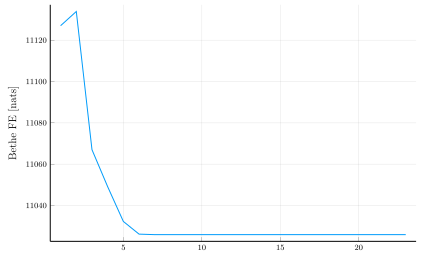

In [24]:
mfe = result.mfe
plot(mfe[3:end], label=:none, ylabel="Bethe FE [nats]")

In [25]:
mean.(result.mws[end])

2-element Vector{Matrix{Float64}}:
 [22.361166430997333 -2.5385938974477904; -2.5385938974477904 22.57935299563393]
 [18.155283221044293 1.0060373149268718; 1.0060373149268718 17.80781390070673]

In [26]:
mean(result.mA[end])

2×2 Matrix{Float64}:
 0.740173  0.431864
 0.259827  0.568136

In [27]:
gen_A

2×2 Matrix{Float64}:
 0.740813  0.298081
 0.259187  0.701919

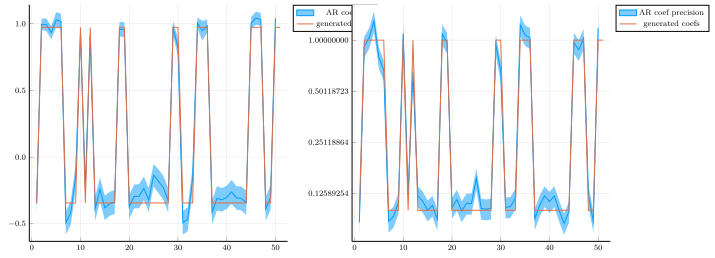

In [28]:
dimension(n) = (x) -> map(i -> i[n], x)
index = 1
mγs = result.mγs
mθs = result.mθs

p1 = plot(mean.(mθs[end]) |> dimension(index), ribbon = sqrt.(var.(mθs[end]) |> dimension(index)), label="AR coef $(index)")
plot!([coefs_set[state][index] for state in real_states], label="generated coefs")
p2 = plot(mean.(mγs[end]), ribbon = std.(mγs[end]), yscale = :log10, label="AR coef $(precision)")
plot!([prec_set[state] for state in real_states], label="generated coefs")

plot(p1, p2, size = (900, 400))

In [29]:
using Colors
cols = distinguishable_colors(2, [RGB(0,0.0,0), RGB(1.0,1.0,0.9)], dropseed=true)
colors = collect(Iterators.flatten(map(e -> Iterators.repeated(e, l_slice), real_states[1:end-1])))
real_colors = map(x -> cols[x], colors)

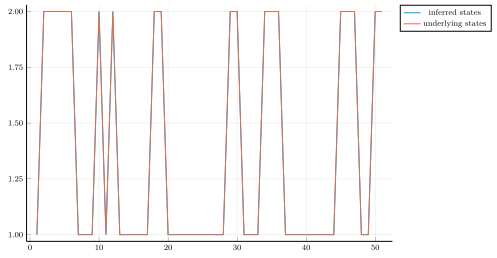

In [30]:
mzs = result.mzs
real_states = last.(findmax.(gen_states))
plot(mean.(mzs[end][1:end]), label="inferred states")
plot!(real_states, label="underlying states")

In [31]:
start, to = 1, 10
i = 9
outputs[start+(i-1)*l_slice:start+i*l_slice]

101-element Vector{Float64}:
 -2.726142199539651
 -0.4768218349164486
  4.15051706009733
 -2.0869983719265903
 -0.8136546312638986
 -0.4484102474261123
  1.7958591648822062
  3.729894543510235
 -2.1401995636676583
 -4.380829133245676
  1.0173602942799818
  1.3954150075495138
  1.7175461979021187
  ⋮
 -3.2380842574434925
  0.5686017185865637
 -5.868731995872107
  3.6921838257245225
 -0.1296687432060497
  1.5785250215465902
  0.8878192025967209
  2.291882644273657
  5.3528083726475
 -5.08132037186937
 -9.196871323319586
 -4.165186790083032

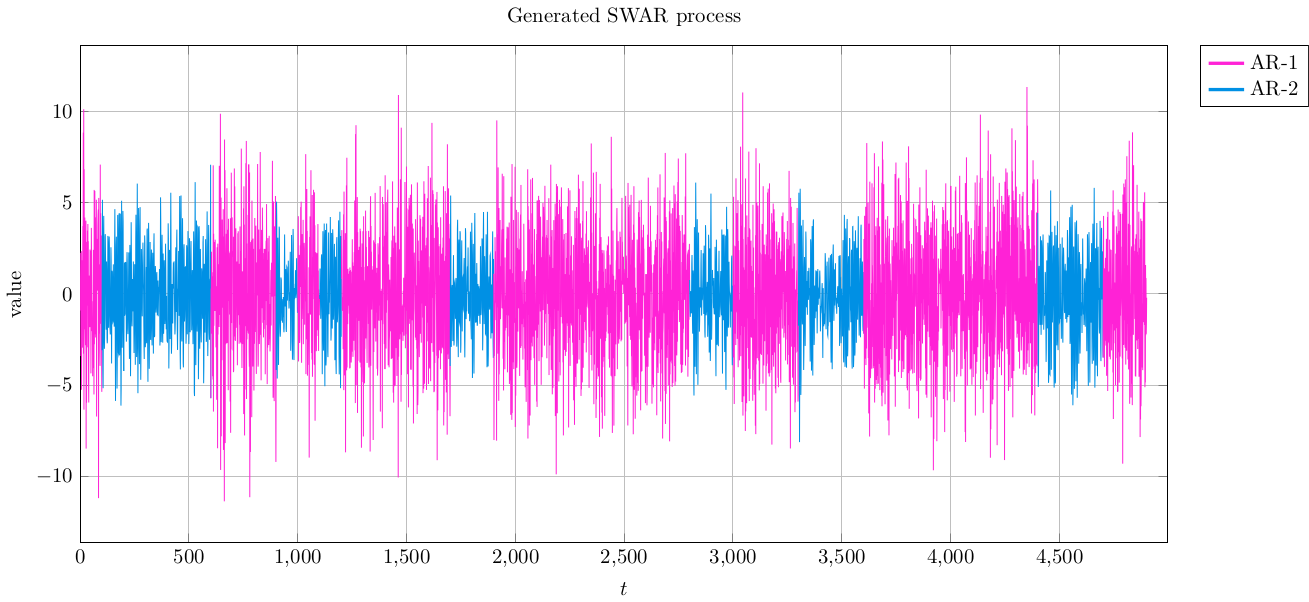

In [32]:
start, to = 1, n_buckets-1
# xtick = from*ar_data_len:1000:to*ar_data_len,
axis1 = @pgf Axis({xlabel=L"t",
        title="Generated SWAR process",
            yticklabel_style={
            "/pgf/number format/fixed,
            /pgf/number format/precision=3"
            },
           ylabel="value", scaled_x_ticks="base 10:0",
           legend_pos = "outer north east",
           xmin=0.0, xmax=length(outputs),
           legend_cell_align="{left}",
           grid = "major", style={"thin"},
           width="20cm", height="10cm",
    },
    Plot({no_marks, style={"ultra thick"}, color=cols[1]}, Coordinates(zeros(1), zeros(1))), LegendEntry("AR-1"),
    Plot({no_marks, style={"ultra thick"}, color=cols[2]}, Coordinates(zeros(1), zeros(1))), LegendEntry("AR-2"),
    Iterators.flatten([
                      [Plot(
                            {no_marks, color=real_colors[start+i*l_slice-1]},
                            Coordinates(
                                 collect(start+(i-1)*l_slice:start+i*l_slice), 
                                 outputs[start+(i-1)*l_slice:start+i*l_slice]
                            ),
                        ) for i in start:to]])...
)

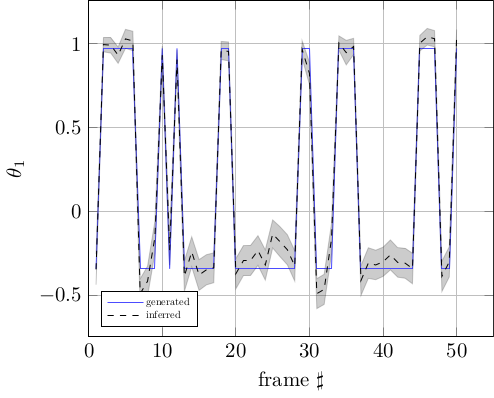

In [33]:
index = 1
dimension(n) = (x) -> map(i -> i[n], x)

plt_states = @pgf Axis(
    {   xlabel="frame "*L" \sharp",
        xmin=0.0,
        legend_pos = "south west",
        legend_cell_align="{left}",
        grid = "major",
        ylabel=L"\theta_{1}",
        legend_style = "{nodes={scale=0.5, transform shape}}",
    },
    Plot({no_marks,color="blue!70"}, Coordinates(collect(1:n_buckets), [coefs_set[state][index] for state in real_states[1:end-1]])), LegendEntry("generated"),
    Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:n_buckets), mean.(result.mθs[end]) |> dimension(index))),
    Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:n_buckets), (mean.(result.mθs[end]) |> dimension(index)) .+  (sqrt.(var.(result.mθs[end]) |> dimension(index))) )),
    Plot({"name path=g", no_marks, color="black",opacity=0.2}, Coordinates(collect(1:n_buckets), (mean.(result.mθs[end]) |> dimension(index)) .-  (sqrt.(var.(result.mθs[end]) |> dimension(index))) )),
    Plot({ thick, color = "blue", fill = "black", opacity = 0.2 },
            raw"fill between [of=f and g]"), LegendEntry("inferred")
)


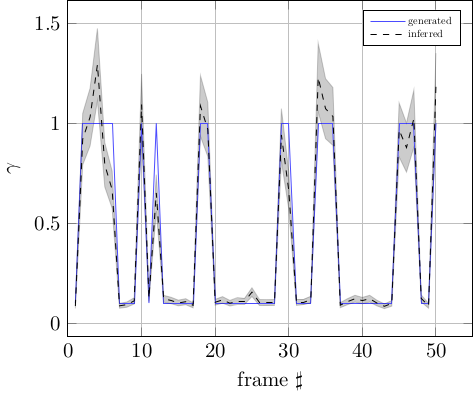

In [34]:
mγs = result.mγs
real_states = last.(findmax.(gen_states))

plt_gamma = @pgf Axis(
{   xlabel="frame "*L" \sharp",
    xmin=0.0,
    legend_pos = "north east",
    legend_cell_align="{left}",
    grid = "major",
    ylabel=L"\gamma",
    legend_style = "{nodes={scale=0.5, transform shape}}",
},
Plot({no_marks,color="blue!70"}, Coordinates(collect(1:n_buckets), [prec_set[state] for state in real_states[1:end-1]])), LegendEntry("generated"),
Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:n_buckets), mean.(mγs[end]))),
Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:n_buckets), mean.(mγs[end]) .+  std.(mγs[end]))),
Plot({"name path=g", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:n_buckets), mean.(mγs[end]) .-  std.(mγs[end]))),
Plot({ thick, color = "blue", fill = "black", opacity = 0.2 },
        raw"fill between [of=f and g]"), LegendEntry("inferred")
)

In [35]:
mean.(result.mzs[end])

50-element Vector{Float64}:
 1.0000000000656526
 1.999999999998265
 1.999999999998265
 1.999999999998265
 1.999999999998265
 1.999999999997624
 1.0000000000085356
 1.0000000000075968
 1.0000000290516466
 1.9999999999975824
 1.000000000782597
 1.9999999999970768
 1.000000000008406
 ⋮
 1.0000000000097773
 1.0000000000050422
 1.000000000052117
 1.000000000004447
 1.0000000000908096
 1.0000000000171863
 1.999999999998265
 1.999999999998265
 1.999999999997624
 1.000000000040917
 1.00000000025273
 1.9999999999982874

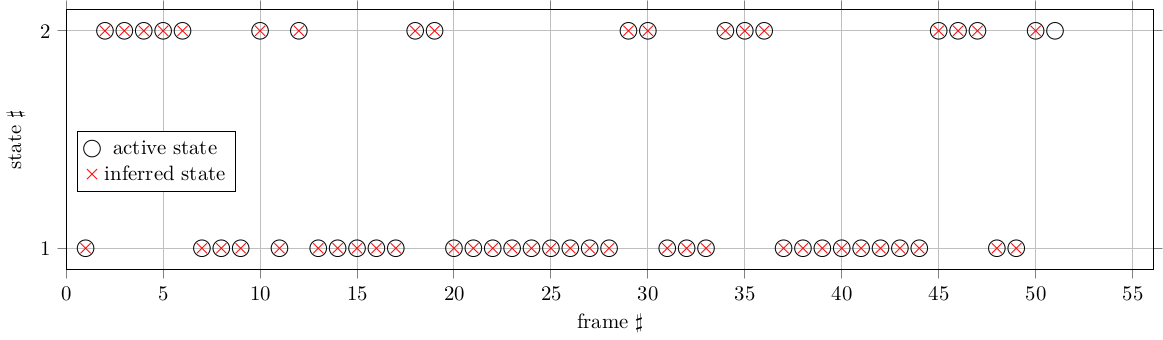

In [36]:
plt_states = @pgf Axis({
    yticklabel_style={
    "/pgf/number format/fixed,
    /pgf/number format/precision=3"
    },
    legend_style="{at={(0.01,0.3)},anchor=south west}",
    grid="major",
    yminorgrids=true,
    xmin=0.0,
    tick_align="outside",
    scaled_y_ticks = false,
    ytick_distance=1, grid = "major", style={"thin"},
    width="20cm", height="6cm",
    xlabel="frame "*L" \sharp", ylabel="state "*L" \sharp",
},
Plot(
    {only_marks,color="black",fill_opacity=0.0, mark_size=4.0, mark="*"},
        Table(
            {x = "x", y = "y"},
             x = collect(1:length(real_states)), y = real_states
        )
    ), LegendEntry("active state"),
Plot(
    {fill="black", only_marks,color="red", mark_size=3.5, opacity=1.0, mark="x"},
        Table(
            {x = "x", y = "y"},
             x = collect(1:length(mzs[end])), y = round.(mean.(mzs[end][1:end]))
        ),
    ), LegendEntry("inferred state"),
)



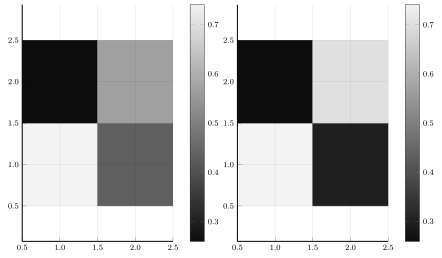

In [37]:
mA = result.mA
xs = collect(1:n_states)
ys = collect(1:n_states)
p1 = heatmap(xs, ys, mean(mA[end]), aspect_ratio = 1,color=:grays)
p2 = heatmap(xs, ys, gen_A, aspect_ratio = 1, color=:grays)
plot(p1, p2)

In [38]:
# axis1 = @pgf Axis(
#     {
#         xtick=collect(0:n_states),
#         ytick=collect(0:n_states),
#         title="Inferred state transition probabilities",
#         legend_pos = "north east",
#         legend_cell_align="{left}",
#         grid = "major",
#         view = (0, 90),
#         colorbar,
#         "colormap/blackwhite",
#         colorbar_style={"xticklabel pos=upper"}
#     },
#     Plot3(
#         {
#             surf,
#             shader = "flat corner",
#         },
#         Coordinates(collect(1:3), collect(1:3), mean(mA[end]))),
#     )